In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import os

In [26]:
#set up variables
sample_krk_dataset = mne.time_frequency.read_spectrum(
    r"D:\mgr_disc\Final\Krk_spectral_tensors\101_epo_ec-psd.hdf5"
)

sample_wwa_dataset = mne.time_frequency.read_spectrum(
    r"D:\mgr_disc\Final\Wwa_spectral_tensors\002_epo_eo-psd.hdf5"
)

n_chans_krk = len(sample_krk_dataset.info['ch_names'])
n_chans_wwa = len(sample_wwa_dataset.info['ch_names'])

epoch_len_krk = np.shape(sample_krk_dataset.get_data())[2]#cause it comes in a shape nepochs, nchans, epochlen
epoch_len_wwa = np.shape(sample_wwa_dataset.get_data())[2]

shape_krk = (n_chans_krk, epoch_len_krk)
shape_wwa = (n_chans_wwa, epoch_len_wwa)

psds_ec_krk = np.zeros(shape_krk)
psds_eo_krk = np.zeros(shape_krk)
psds_ec_wwa = np.zeros(shape_wwa)
psds_eo_wwa = np.zeros(shape_wwa)

#getting x axis for plots
freqs_krk = np.load(r"D:\mgr_disc\freq_vectors\freqs_krk.npy")
freqs_wwa = np.load(r"D:\mgr_disc\freq_vectors\freqs_wwa.npy")

In [27]:
#create spectrum objects averaged across people

#have to do it separetely for both cities
cities = ['Krk', 'Wwa']
nparticipants = {}#hold the information about number of the participant in each city

for city in cities:
    
    read_dir = rf"D:\mgr_disc\Final\{city}_spectral_tensors"
    os.chdir(read_dir)
    files_all = os.listdir()
    files_ec = [x for x in files_all if 'ec' in x]
    files_eo = [x for x in files_all if 'eo' in x]
    
    ##number for participants for future normalisation-differs between cities
    nparticipants[city] = len(files_ec)
    
    ##upload data from every single participant
    for i in range(len(files_ec)):
        
        psd_ec = mne.time_frequency.read_spectrum(os.path.join(read_dir, files_ec[i]))
        psd_eo = mne.time_frequency.read_spectrum(os.path.join(read_dir, files_eo[i]))
        
        ##average across epochs
        psd_ec_average = psd_ec.average()
        psd_eo_average = psd_eo.average()
        
        ##update 
        if city == 'Krk':
            psds_ec_krk += psd_ec_average.get_data()
            psds_eo_krk += psd_eo_average.get_data()
        elif city == 'Wwa':
            psds_ec_wwa += psd_ec_average.get_data()
            psds_eo_wwa += psd_eo_average.get_data()

##normalise to have a mean
psds_ec_krk /= nparticipants['Krk']
psds_eo_krk /= nparticipants['Krk']
psds_ec_wwa /= nparticipants['Wwa']
psds_eo_wwa /= nparticipants['Wwa']

##average across channels
psds_ec_krk_channel_average = np.mean(psds_ec_krk,axis=0)
psds_eo_krk_channel_average = np.mean(psds_eo_krk,axis=0)
psds_ec_wwa_channel_average = np.mean(psds_ec_wwa,axis=0)
psds_eo_wwa_channel_average = np.mean(psds_eo_wwa,axis=0)

#convert units
psds_ec_krk_channel_average = 10 * np.log10(psds_ec_krk_channel_average * 10**12)
psds_eo_krk_channel_average = 10 * np.log10(psds_eo_krk_channel_average * 10**12)
psds_ec_wwa_channel_average = 10 * np.log10(psds_ec_wwa_channel_average * 10**12)
psds_eo_wwa_channel_average = 10 * np.log10(psds_eo_wwa_channel_average * 10**12)

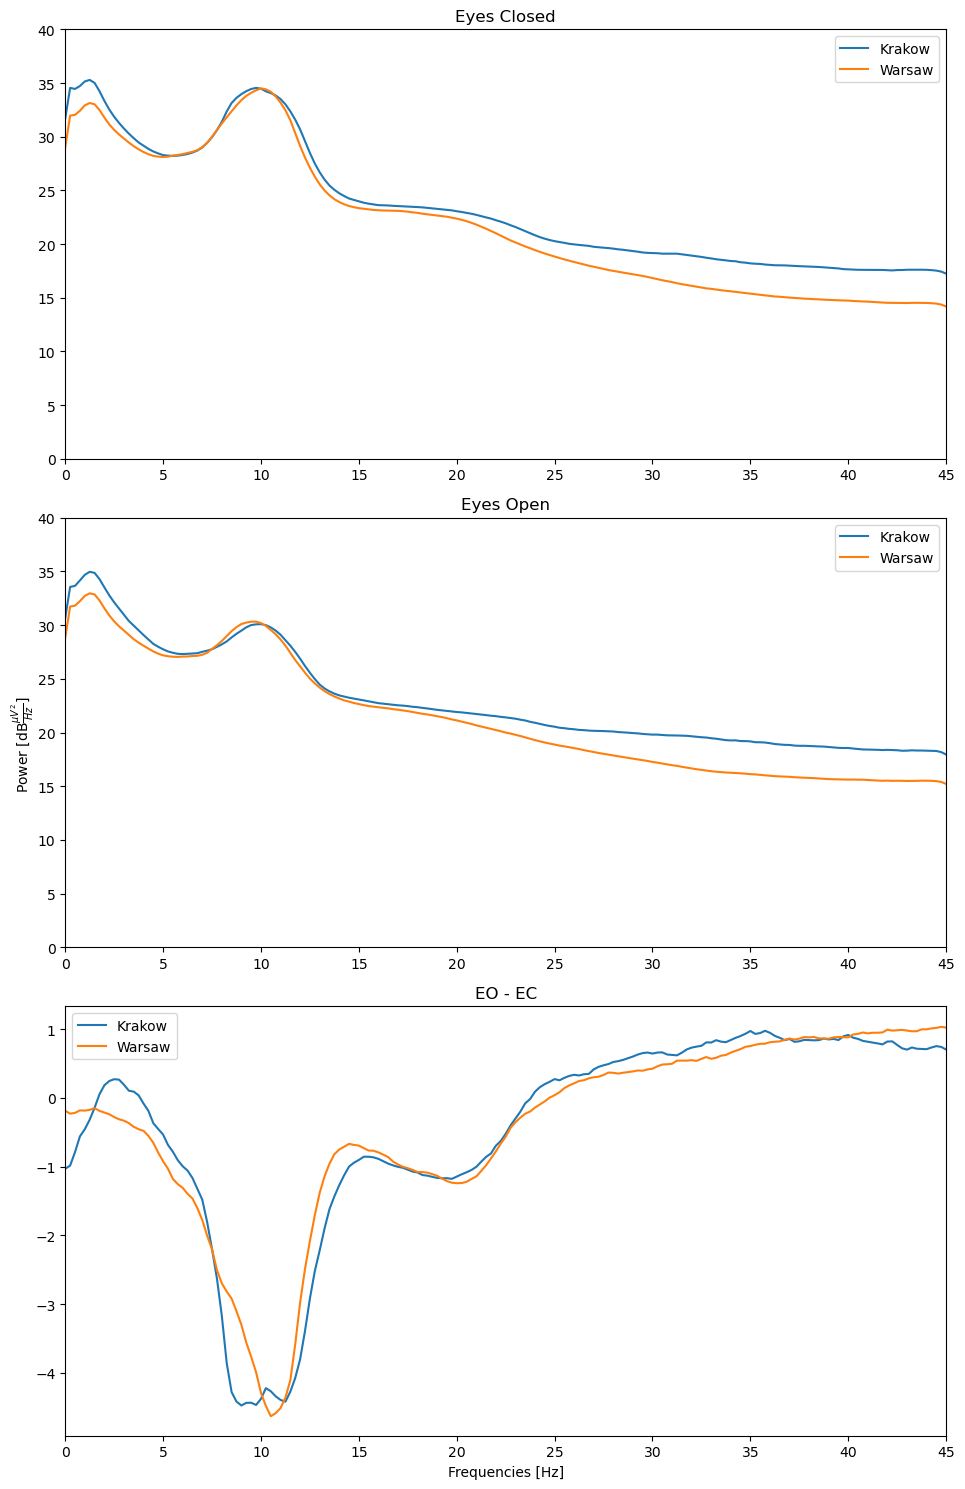

In [38]:
###plot comparing cities and eyes conditions
fig,ax = plt.subplots(3,1)

ax[0].plot(freqs_krk, psds_ec_krk_channel_average, label='Krakow')
ax[0].plot(freqs_wwa, psds_ec_wwa_channel_average, label='Warsaw')
ax[0].legend()
ax[0].set_title('Eyes Closed')
ax[0].set_xlim([0,45])
ax[0].set_ylim([0,40])


ax[1].plot(freqs_krk, psds_eo_krk_channel_average, label='Krakow')
ax[1].plot(freqs_wwa, psds_eo_wwa_channel_average, label='Warsaw')
ax[1].legend()
ax[1].set_title('Eyes Open')
ax[1].set_xlim([0,45])
ax[1].set_ylim([0,40])

ax[2].plot(freqs_krk, psds_eo_krk_channel_average - psds_ec_krk_channel_average, label='Krakow')
ax[2].plot(freqs_wwa, psds_eo_wwa_channel_average - psds_ec_wwa_channel_average, label='Warsaw')
ax[2].legend()
ax[2].set_title('EO - EC')
ax[2].set_xlim([0,45])
ax[2].set_xlabel('Frequencies [Hz]')

fig.set_size_inches(10,15)
fig.text(0.04, 0.5, '$\\text{Power [dB} \\frac{\\mu V^2} {Hz} \\text{]}$', va='center', rotation='vertical')
fig.tight_layout(rect=[0.05, 0, 1, 1])  # leave space for the fig.text
#fig.tight_layout()